# Validating Assumptions About Data - first part

This notebook demonstrates that the images with higher speeds differ more than the images with lower speeds.

## Setup
- Download and unpack training data
- Create DonkeyCar project and load configuration

In [6]:
import os

# do we have the correct env loaded?
assert 'donkey' == os.environ['CONDA_DEFAULT_ENV'], os.environ['CONDA_DEFAULT_ENV']

## 4.1.1 Driving Speed Differences



In [7]:
import numpy as np
fast = [282, 275, 268, 281, 280, 318, 336, 306, 281, 283, 290, 304, 338, 313, 294, 295, 308, 294, 275, 297, 278, 282,
        296, 318, 304, 291, 299, 302, 300, 309, 269, 284, 293, 286, 278, 292, 285, 291, 300, 295, 291, 293, 291, 286,
        293, 287, 299, 294, 292, 298, 295, 298, 308, 300, 293, 288, 316, 360, 314, 319, 323, 296, 298, 286]

slow = [552, 471, 576, 516, 439, 453, 475, 462, 489, 505, 496, 549, 519, 527, 526, 430, 382, 481, 499, 483, 514, 526,
        554, 495, 424, 454, 484, 481, 481, 483, 485, 480, 468, 484, 464, 468, 479, 448, 484, 444, 463]

fast = np.array(fast)/20
slow = np.array(slow)/20

len(fast), np.mean(fast), np.std(fast), len(slow), np.mean(slow), np.std(slow)

(64, 14.834375, 0.8078653875337152, 41, 24.259756097560974, 1.8723996443912498)

### Figure 9. Lap speeds for fast and slow data.

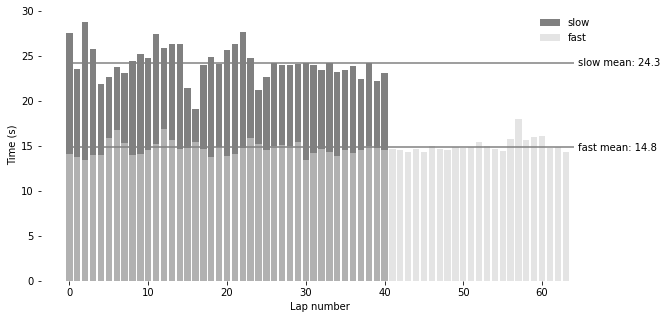

In [9]:

from matplotlib import pyplot as plt

def plot_(fast, slow):
    fig, ax = plt.subplots(figsize=(10, 5))
    length = max((len(fast), len(slow)))
    ax.bar(range(len(slow)), slow, label='slow', color='grey')
    ax.bar(range(len(fast)), fast, label='fast', color='lightgrey', alpha=0.6)

    ax.text(length + 0.5, fast.mean(), f'fast mean: {fast.mean():.1f}', ha='left', va='center')
    ax.hlines(fast.mean(), 0, length, colors='grey', zorder=999)
    ax.text(length + 0.5, slow.mean(), f'slow mean: {slow.mean():.1f}', ha='left', va='center')
    ax.hlines(slow.mean(), 0, length, colors='grey', zorder=999)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xlabel('Lap number')
    ax.set_ylabel('Time (s)')
    ax.legend(frameon=False)


plot_(fast, slow)

## 4.1.2 Frame Differences

In [10]:
import sys

sys.path.append('donkeycar')
sys.path.append('src')

In [11]:

import donkeycar as dk

cfg = dk.load_config(config_path='mycar/config.py')
cfg.SEQUENCE_LENGTH = 2

loading config file: mycar/config.py
loading personal config over-rides from myconfig.py


### Load data

In [12]:
from dataloader import load_records

fast_speed_data = load_records('faster-autodrive', cfg, 'data', None)
slow_speed_data = load_records('slower-autodrive', cfg, 'data', None)


INFO:donkeycar.pipeline.types:Loading only the first tub from paths ['data/faster-autodrive']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/faster-autodrive/catalog_20.catalog


INFO:donkeycar.pipeline.types:Loading only the first tub from paths ['data/slower-autodrive']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/slower-autodrive/catalog_20.catalog


### On average, do two consecutive images/frames differ more for bigger speeds?

In [37]:
def mse(image1, image2):
    return np.array((image1 - image2) ** 2).mean()


def rmse(image1, image2):
    return np.sqrt(mse(image1, image2))

In [12]:
from donkeycar.pipeline.augmentations import ImageAugmentation
from skimage.metrics import normalized_root_mse, mean_squared_error
import pandas as pd

transformation = ImageAugmentation(cfg, 'TRANSFORMATIONS')
tub_records = dict(fast=fast_speed_data, slow=slow_speed_data)
for_df = []
for speed, records in tub_records.items():
    for (first_tubrecord, second_tubrecord) in records:
        first_image = first_tubrecord.image()
        first_image = transformation.run(first_image)

        second_image = second_tubrecord.image()
        second_image = transformation.run(second_image)

        my_mse = mse(second_image, first_image)
        mse_ = mean_squared_error(second_image, first_image)
        rmse_ = rmse(second_image, first_image)
        nrmse = normalized_root_mse(second_image, first_image)

        tubrecord_index = first_tubrecord.underlying['_index']
        for_df.append([tubrecord_index, speed, mse_, rmse_, nrmse, my_mse])

df = pd.DataFrame(for_df, columns=['tubrecord_index', 'speed', 'MSE', 'RMSE', 'NRMSE', 'MY_MSE'])
df

In [ ]:
df.to_csv('image_diffs.csv.gz', index=False)

df.describe()

### Figure 10. Fast and slow driving frame pixel value differences.

In [15]:
import pandas as pd

df = pd.read_csv('image_diffs.csv.gz')

df.groupby('speed').MSE.mean(),

(speed
 fast    38.238296
 slow    22.354597
 Name: MSE, dtype: float64,)

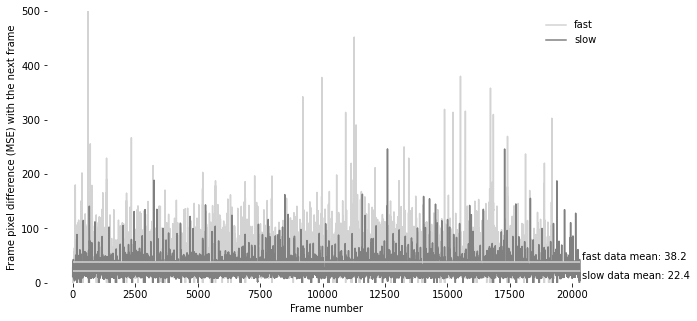

In [82]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

fast = df[df.speed == 'fast'].MSE
slow = df[df.speed == 'slow'].reset_index().MSE
length = max((len(fast), len(slow)))

ax.plot(fast, label='fast', c='lightgrey')
ax.plot(slow, label='slow', c='grey')

ax.text(length + 100, fast.mean() + 10, f'fast data mean: {fast.mean():.1f}', ha='left', va='center')
ax.hlines(fast.mean(), 0, length, colors='lightgrey', zorder=999)

ax.text(length + 100, slow.mean() - 10, f'slow data mean: {slow.mean():.1f}', ha='left', va='center')
ax.hlines(slow.mean(), 0, length, colors='lightgrey', zorder=999)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.legend(frameon=False)

ax.set_xlabel('Frame number')
ax.set_ylabel('Frame pixel difference (MSE) with the next frame')
ax.set_ylim(0, 500)
pass


### Conclusion
Images are more different for faster speeds